# DRP Attack Tutorial Notebook

### load libraries

In [1]:
%matplotlib inline
import sys
import os
sys.path.append(os.getcwd() + '/openpilot')
sys.path.append(os.getcwd() + './comma2k19/notebooks/lib/')


os.environ["CUDA_VISIBLE_DEVICES"]="-1"
import pickle
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from logging import StreamHandler, Formatter, FileHandler, getLogger

import numpy as np

from selfdrive.controls.lib.lane_planner import LanePlanner

from car_motion_attack.models import create_model
from car_motion_attack.model_output_postprocess import postprocess
from car_motion_attack.utils import yuv2rgb, rgb2yuv
from car_motion_attack.polyfuzz.polyfuzz import PolyFuzz, VehicleState
from car_motion_attack.polyfuzz.utils.parse_model_output import parse_model_output
from car_motion_attack.load_sensor_data import load_sensor_data, load_transform_matrix
from car_motion_attack.car_motion import CarMotion
from car_motion_attack.config import MODEL_IMG_HEIGHT, MODEL_IMG_WIDTH, CAMERA_IMG_HEIGHT, CAMERA_IMG_WIDTH, SKY_HEIGHT

class LaneLine:
    def __init__(self, poly, prob, points=None):
        self.poly = poly
        self.points = points
        self.prob = prob

class ModelOutput:
    def __init__(self, l_poly, r_poly, p_poly, l_prob, r_prob):
        self.leftLane = LaneLine(l_poly, l_prob)
        self.rightLane = LaneLine(r_poly, r_prob)
        self.path = LaneLine(p_poly, 1.)

IMG_INPUT_SHAPE = (1, 6, MODEL_IMG_HEIGHT, MODEL_IMG_WIDTH)
IMG_INPUT_MASK_SHAPE = (1, 1, MODEL_IMG_HEIGHT, MODEL_IMG_WIDTH)
RNN_INPUT_SHAPE = (1, 512)
MODEL_DESIRE_INPUT_SHAPE = (1, 8)
MODEL_OUTPUT_SHAPE = (1, 1724)

LANE_INTERVAL = 93
LANE_WIDTH = 1.5
LANE_DOT_LENGTH = 23


model = create_model()
model.load_weights('data/model_keras_20191230_v0.7/driving_model.h5')


Using TensorFlow backend.
/home/takamisato/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/takamisato/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/takamisato/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype

# Scenario configulation

* Adjust Bird-eye-view

In [2]:
### load scenario data
name = 'highway_sc1'
path = "data/scenarios/highway/sc1/"

sc_start = 0
n_frames = 20
scale = 5
patch_lateral_shift = 0
starting_meters = 7

left_lane_pos = 6
right_lane_pos = 36

patch_width = 45
patch_length = 300

    
global_bev_mask = np.random.random((patch_length * scale, patch_width * scale)) > 0

global_bev_mask[:, left_lane_pos * scale:int((left_lane_pos + LANE_WIDTH) * scale)] = False
global_bev_mask[:, right_lane_pos * scale:int((right_lane_pos + LANE_WIDTH) * scale)] = False



df_sensors = load_sensor_data(
   path, offset=sc_start
).head(n_frames)
list_bgr_img = [cv2.imread(path + f"imgs/{i}.png") for i in range(sc_start, sc_start + n_frames)]

In [3]:
### Human driving info
df_sensors

t      speed        mph  steering_angle  lateral_shift  \
0   1594.624464  34.795833  77.838279       -4.500000       0.000000   
1   1594.674460  34.816580  77.884689       -4.500000       0.000000   
2   1594.724458  34.802196  77.852512       -4.013894      -0.001606   
3   1594.774456  34.781808  77.806904       -2.846611      -0.005145   
4   1594.824465  34.789380  77.823842       -1.163740      -0.010642   
5   1594.874459  34.801340  77.850597       -0.800000      -0.017949   
6   1594.924460  34.826596  77.907096       -1.000000      -0.026566   
7   1594.974473  34.792644  77.831144       -0.800000      -0.036004   
8   1595.024458  34.772898  77.786974       -1.100000      -0.046448   
9   1595.074453  34.810110  77.870216       -1.200000      -0.057644   
10  1595.124452  34.800447  77.848600       -1.253905      -0.069767   
11  1595.174458  34.833628  77.922826       -1.825675      -0.082510   
12  1595.224468  34.822111  77.897062       -2.200000      -0.095650   
13  1595.274484  34.772203  77.785417       -2.000000      -0.109206   
14  1595.324453  34.804491  77.857647       -2.100000      -0.123628   
15  1595.374451  34.821634  77.895994       -1.830648      -0.138974   
16  1595.424451  34.821636  77.896000       -1.236434      -0.154876   
17  1595.474460  34.814378  77.879764       -1.100000      -0.171206   
18  1595.524450  34.769176  77.778648       -1.200000      -0.187725   
19  1595.574449  34.790338  77.825986       -1.100000      -0.204583   

    longitude_shift       yaw    t_diff  distance  
0          0.000000  0.000000  0.000000  0.000000  
1          1.761423 -0.001066  0.049996  1.740690  
2          3.522525 -0.002355  0.049998  1.740040  
3          5.283575 -0.003623  0.049998  1.739021  
4          7.045110 -0.004640  0.050009  1.739782  
5          8.806118 -0.005278  0.049994  1.739858  
6         10.567492 -0.005596  0.050001  1.741365  
7         12.329332 -0.005775  0.050013  1.740084  
8         14.090341 -0.005823  0.049985  1.738123  
9         15.851965 -0.005769  0.049995  1.740331  
10        17.613621 -0.005812  0.049999  1.739988  
11        19.375477 -0.005942  0.050006  1.741890  
12        21.137412 -0.006127  0.050010  1.741454  
13        22.899341 -0.006474  0.050016  1.739166  
14        24.659859 -0.006906  0.049969  1.739146  
15        26.421522 -0.007351  0.049998  1.741012  
16        28.182968 -0.007772  0.050000  1.741082  
17        29.944889 -0.008110  0.050009  1.741032  
18        31.706273 -0.008320  0.049990  1.738111  
19        33.468068 -0.008475  0.049999  1.739482

In [4]:
### Transformation matrix extraction. For this scenaroi, transformation matrix is included in the repository.

#from car_motion_attack.load_sensor_data import load_transform_matrix
#trns = load_transform_matrix(path + "raw_log.bz2", start_time=df_sensors.loc[0, "t"])
#np.save(path + 'trns.npy', trns)
roi_mat = np.load(path + 'trns.npy')

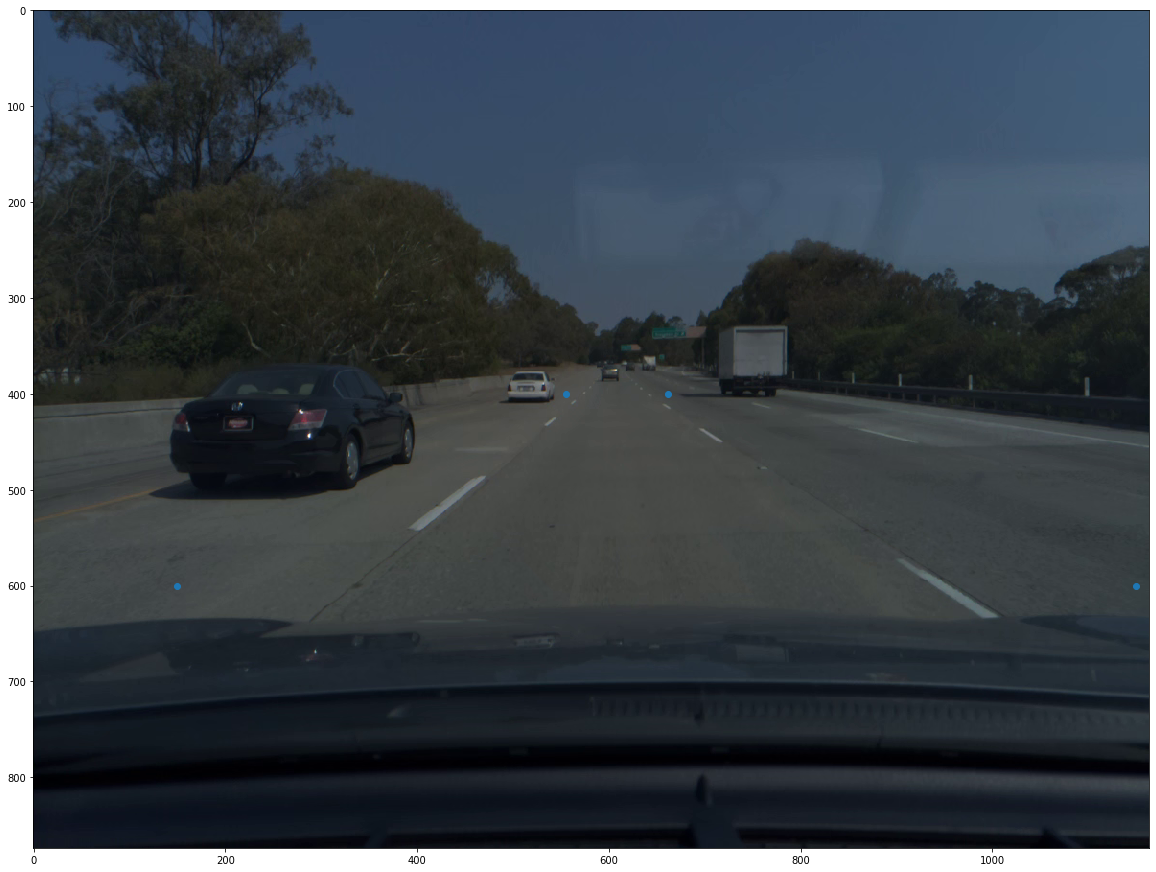

In [5]:
# find 4 corner points for BEV transformation

plt.figure(figsize=(20, 20))

plt.imshow(cv2.cvtColor(list_bgr_img[0], cv2.COLOR_BGR2RGB))
src_corners = np.array(
                [[545.0 + 10, 400.0], 
                 [672.0 - 10, 400.0],
                 
                 [150.0, 600.0],
                 [1150.0, 600.0]],
                dtype=np.float32,
            )

plt.scatter(src_corners[:, 0], src_corners[:, 1])

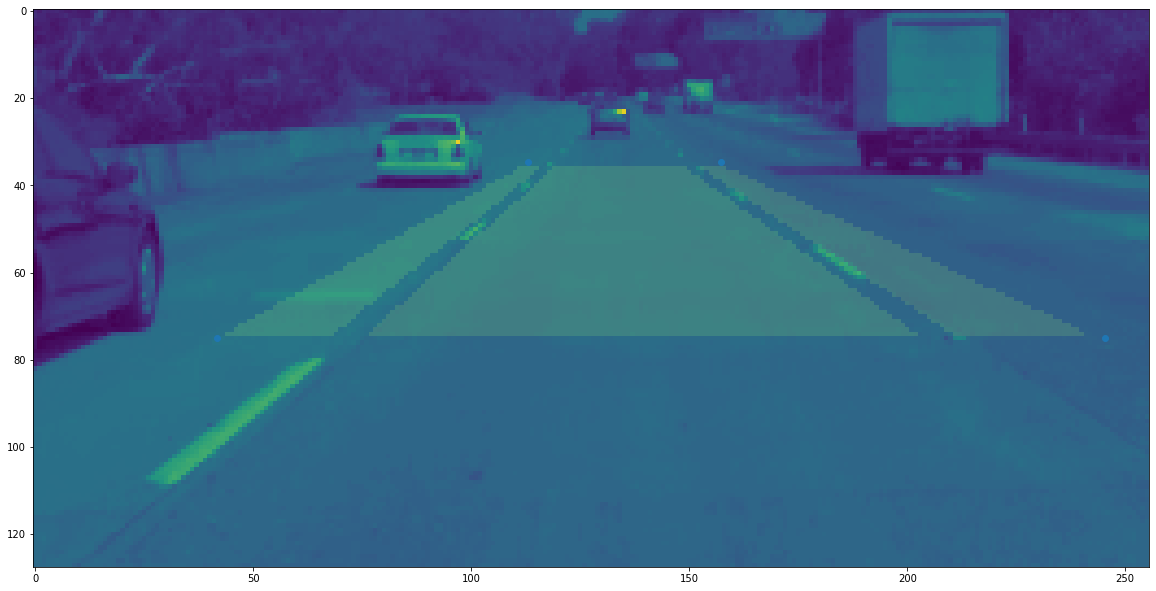

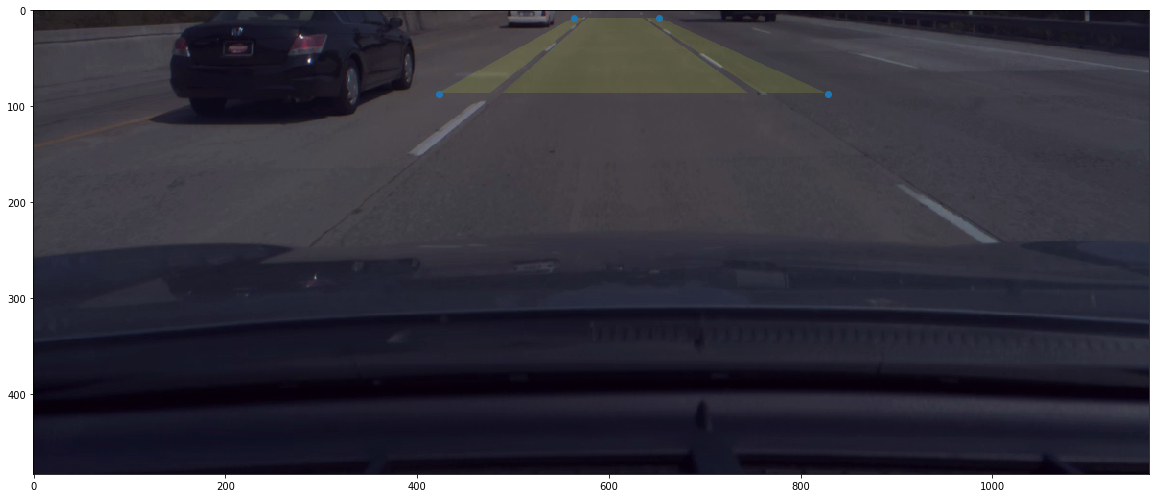

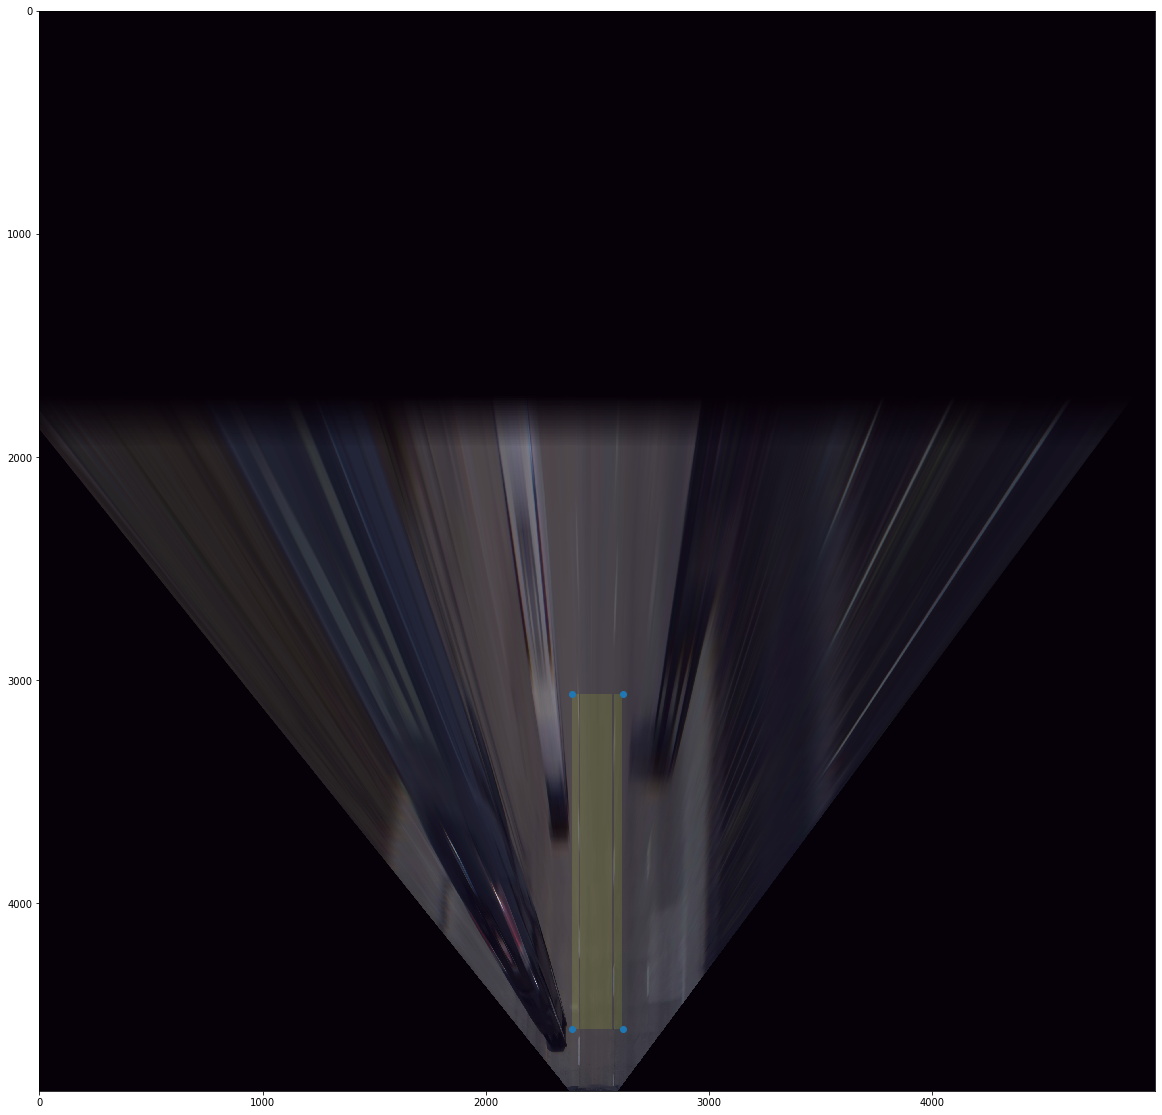

In [6]:
### BEV transformation validation

import matplotlib.patches as patches
#path = "data/straight_scenarios/10/"

car_motion = CarMotion(list_bgr_img, df_sensors, global_bev_mask, roi_mat, scale=scale, src_corners=src_corners)
car_motion.setup_masks(lateral_shift=patch_lateral_shift, starting_meters=starting_meters)

#for i in range(car_motion.n_frames):
#    car_motion.list_transform[i].update_perspective(0, 10)
#    car_motion.list_frame_mask[i].update_mask(0, 10)

list_camera_imgs = car_motion.get_all_camera_images()
list_camera_corners = car_motion.get_all_camera_mask_corners()
list_camera_masks = car_motion.get_all_camera_masks()

list_bev_imgs = car_motion.get_all_bev_images()
list_bev_corners = car_motion.get_all_bev_mask_corners()
list_bev_masks = car_motion.get_all_bev_masks()

list_model_imgs = car_motion.get_all_model_images()
list_model_masks = car_motion.get_all_model_masks()
list_model_corners = car_motion.get_all_model_mask_corners()

plt.figure(figsize=(20, 20))
plt.imshow(list_model_imgs[0].reshape(6, MODEL_IMG_HEIGHT, MODEL_IMG_WIDTH)[0])
plt.imshow(cv2.resize(list_model_masks[0].astype(float), (MODEL_IMG_WIDTH, MODEL_IMG_HEIGHT)), alpha=0.1)
plt.scatter(list_model_corners[0][:, 0] / 2, list_model_corners[0][:, 1] / 2)
plt.show()
plt.figure(figsize=(20, 20))
plt.imshow(list_camera_imgs[0])
plt.imshow(list_camera_masks[0], alpha=0.1)
plt.scatter(list_camera_corners[0][:, 0], list_camera_corners[0][:, 1])
plt.show()
plt.figure(figsize=(20, 20))
plt.imshow(list_bev_imgs[0])
plt.imshow(list_bev_masks[0], alpha=0.1)
plt.scatter(list_bev_corners[0][:, 0], list_bev_corners[0][:, 1])

# Caluculate base color

In [7]:
# Base color is avg. of road surface color
base_color = rgb2yuv(np.tile(list_bev_imgs[0][list_bev_masks[0] > 0].mean(axis=0), (2, 2, 1)))[0, 0, :4].mean()

# Output  configuration

In [8]:
map_config = {'base_color': base_color,
              'data_path': path,
              'n_epoch': 100,
              'n_frames':20,
              'frame_offset': sc_start,
              'scale': scale,
              'patch_lateral_shift': patch_lateral_shift,
              'result_dir': f'./logs/{name}_right/',
              'left_lane_pos': left_lane_pos,
              'right_lane_pos': right_lane_pos,
              'src_corners': src_corners.tolist(),
              'target_deviation': 0.5,
              'is_attack_to_rigth': True,
              'patch_width': patch_width,
              'patch_length': patch_length,
              'starting_meters': starting_meters,
              'l2_weight': 0.001
             }
import json
with open(f'{path}/config_right.json', 'w') as f:
    f.write(json.dumps(map_config))
    
map_config['is_attack_to_rigth'] = False
map_config['result_dir'] = f'./logs/{name}_left/'

with open(f'{path}/config_left.json', 'w') as f:
    f.write(json.dumps(map_config))

In [9]:
map_config

{'base_color': -0.3663711236732341,
 'data_path': 'data/scenarios/highway/sc1/',
 'n_epoch': 100,
 'n_frames': 20,
 'frame_offset': 0,
 'scale': 5,
 'patch_lateral_shift': 0,
 'result_dir': './logs/highway_sc1_left/',
 'left_lane_pos': 6,
 'right_lane_pos': 36,
 'src_corners': [[555.0, 400.0],
  [662.0, 400.0],
  [150.0, 600.0],
  [1150.0, 600.0]],
 'target_deviation': 0.5,
 'is_attack_to_rigth': False,
 'patch_width': 45,
 'patch_length': 300,
 'starting_meters': 7,
 'l2_weight': 0.001}

# Generate attack patch

Please execute the following command.
```bash
python run_patch_generation.py data/scenarios/highway/sc1/config_left.json
```

This generation takes around 5 min.

# Result

### Model input

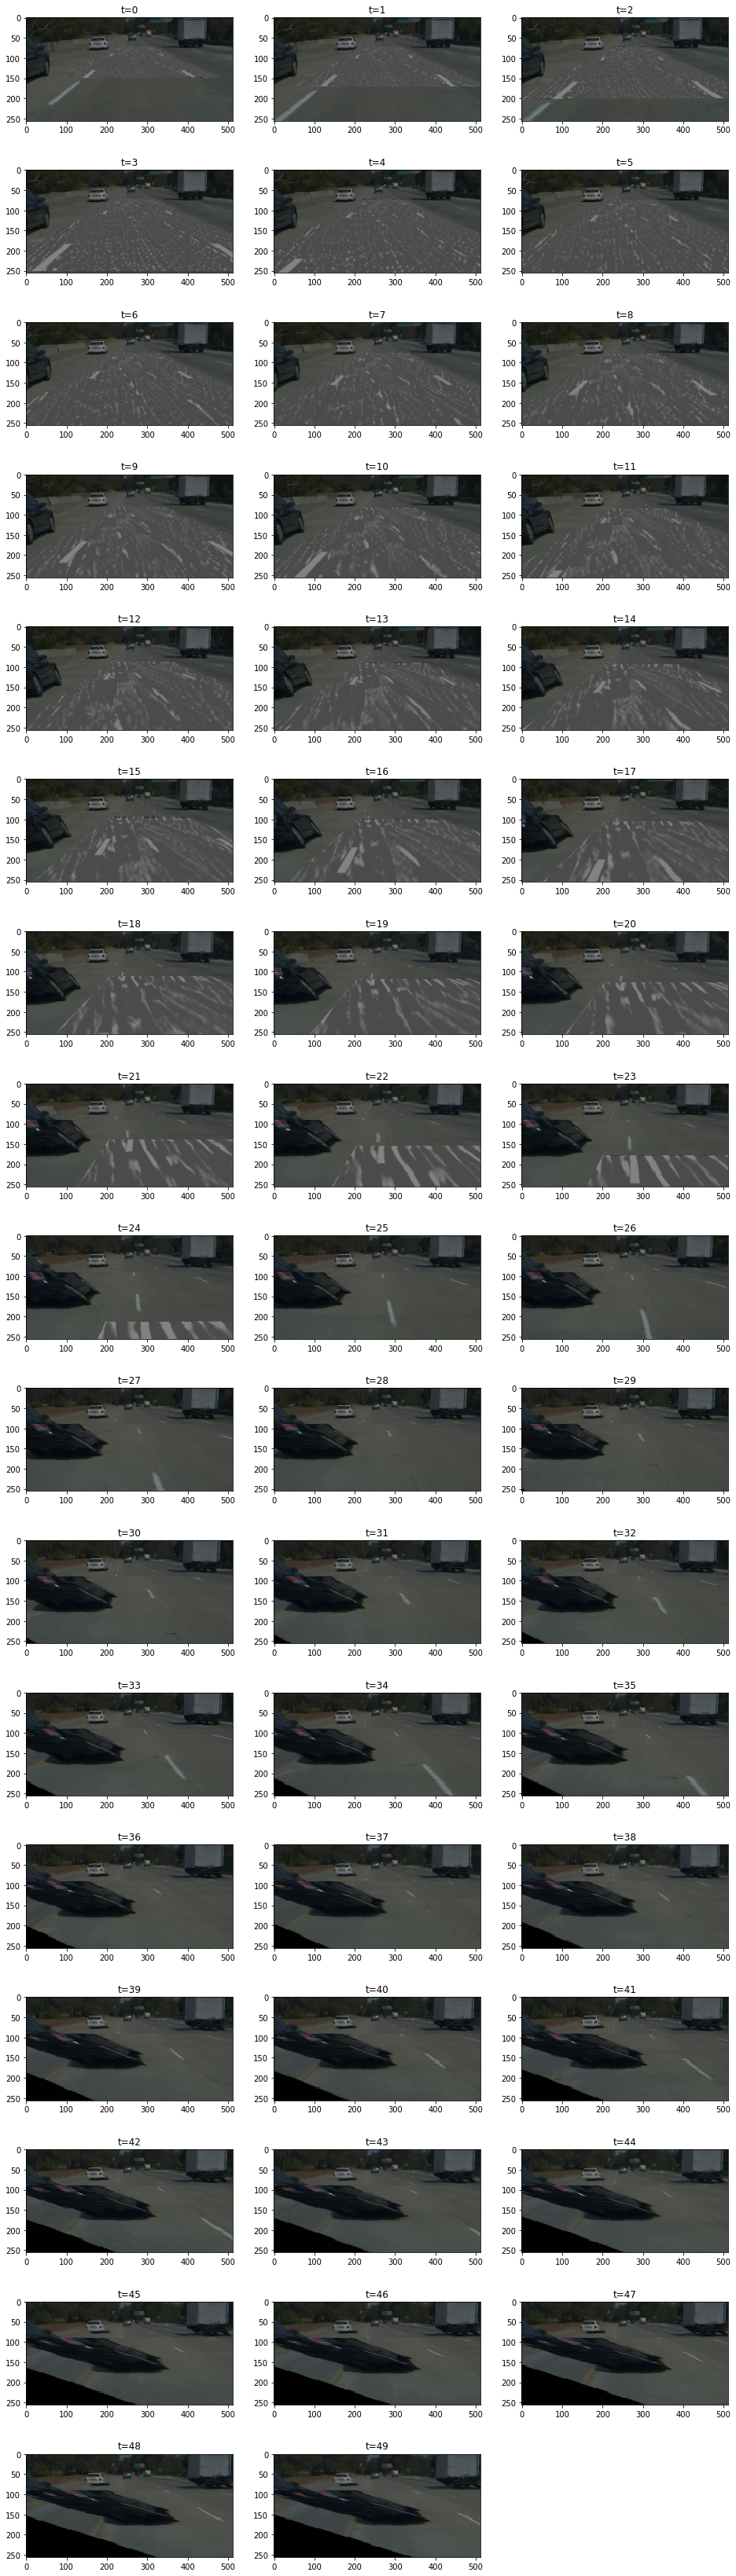

In [10]:
data_path = 'logs/highway_sc1_left/'

n = 100
all_data = np.load(f'{data_path}/replaymodel_img_inputs_{n}.npy') # -1.9767685848626184
all_rnn_data = np.load(f'{data_path}/replaymodel_rnn_inputs_{n}.npy')
plt.figure(figsize=(16, 60))
desire_input = np.zeros(MODEL_DESIRE_INPUT_SHAPE)
list_dfs = []

YUV_MIN = -8.68289960e-01
YUV_MAX = 4.87138199e-01
MODEL_PATH_DISTANCE = 192
POLYFIT_DEGREE = 4
SPEED_PERCENTILES = 10
v_ego = 28.256250

path_start = 0
left_start = MODEL_PATH_DISTANCE * 2
right_start = MODEL_PATH_DISTANCE * 2 + MODEL_PATH_DISTANCE * 2 + 1
lead_start = MODEL_PATH_DISTANCE * 2 + (MODEL_PATH_DISTANCE * 2 + 1) * 2
def poly(p, x):
    return p[0] * (x ** 3) + p[1] * (x ** 2) + p[2] * x + p[3]
    
for t in range(all_data.shape[0]):
    input_ = all_data[t].reshape((IMG_INPUT_SHAPE))

    rnn_input = all_rnn_data[t].reshape(1, 512)
    out = model.predict([input_, desire_input, rnn_input])[0]
    path_poly, left_poly, right_poly, left_prob, right_prob = postprocess(out)
    
    LP = LanePlanner()
    md = ModelOutput(left_poly, right_poly, path_poly, left_prob, right_prob)
    LP.update(v_ego, md)

    df = pd.DataFrame()
    df['path'] = out[path_start:path_start + MODEL_PATH_DISTANCE]
    df['left_lane'] = out[left_start:left_start + MODEL_PATH_DISTANCE] + 1.8
    df['right_lane'] = out[right_start:right_start + MODEL_PATH_DISTANCE] - 1.8
    
    df['path fitted'] = [poly(path_poly, i) for i in range(192)]
    df['left_lane fitted'] = [poly(left_poly, i) for i in range(192)]
    df['right_lane fitted'] = [poly(right_poly, i) for i in range(192)]
    df['desired_path fitted'] = [poly(LP.d_poly, i) for i in range(192)]

    list_dfs.append(df)
    rgb = yuv2rgb(input_[0].transpose((1, 2, 0)).clip(YUV_MIN, YUV_MAX))

    ax = plt.subplot(all_data.shape[0] // 3 + 1, 3, t + 1)
    ax.set_title(f't={t}')
    ax.imshow(rgb.clip(0, 255).astype(np.uint8))

plt.show()

### Detected Lane line

* path: expected driving path (model output)
* left & right lane: detected lane lines (model output)
* left_lane & right lane fitted: 3-degree polynomial fitting of left & right lane
* desired fitted: setpoint for MPC. calculated from path, left lane, and right lane.

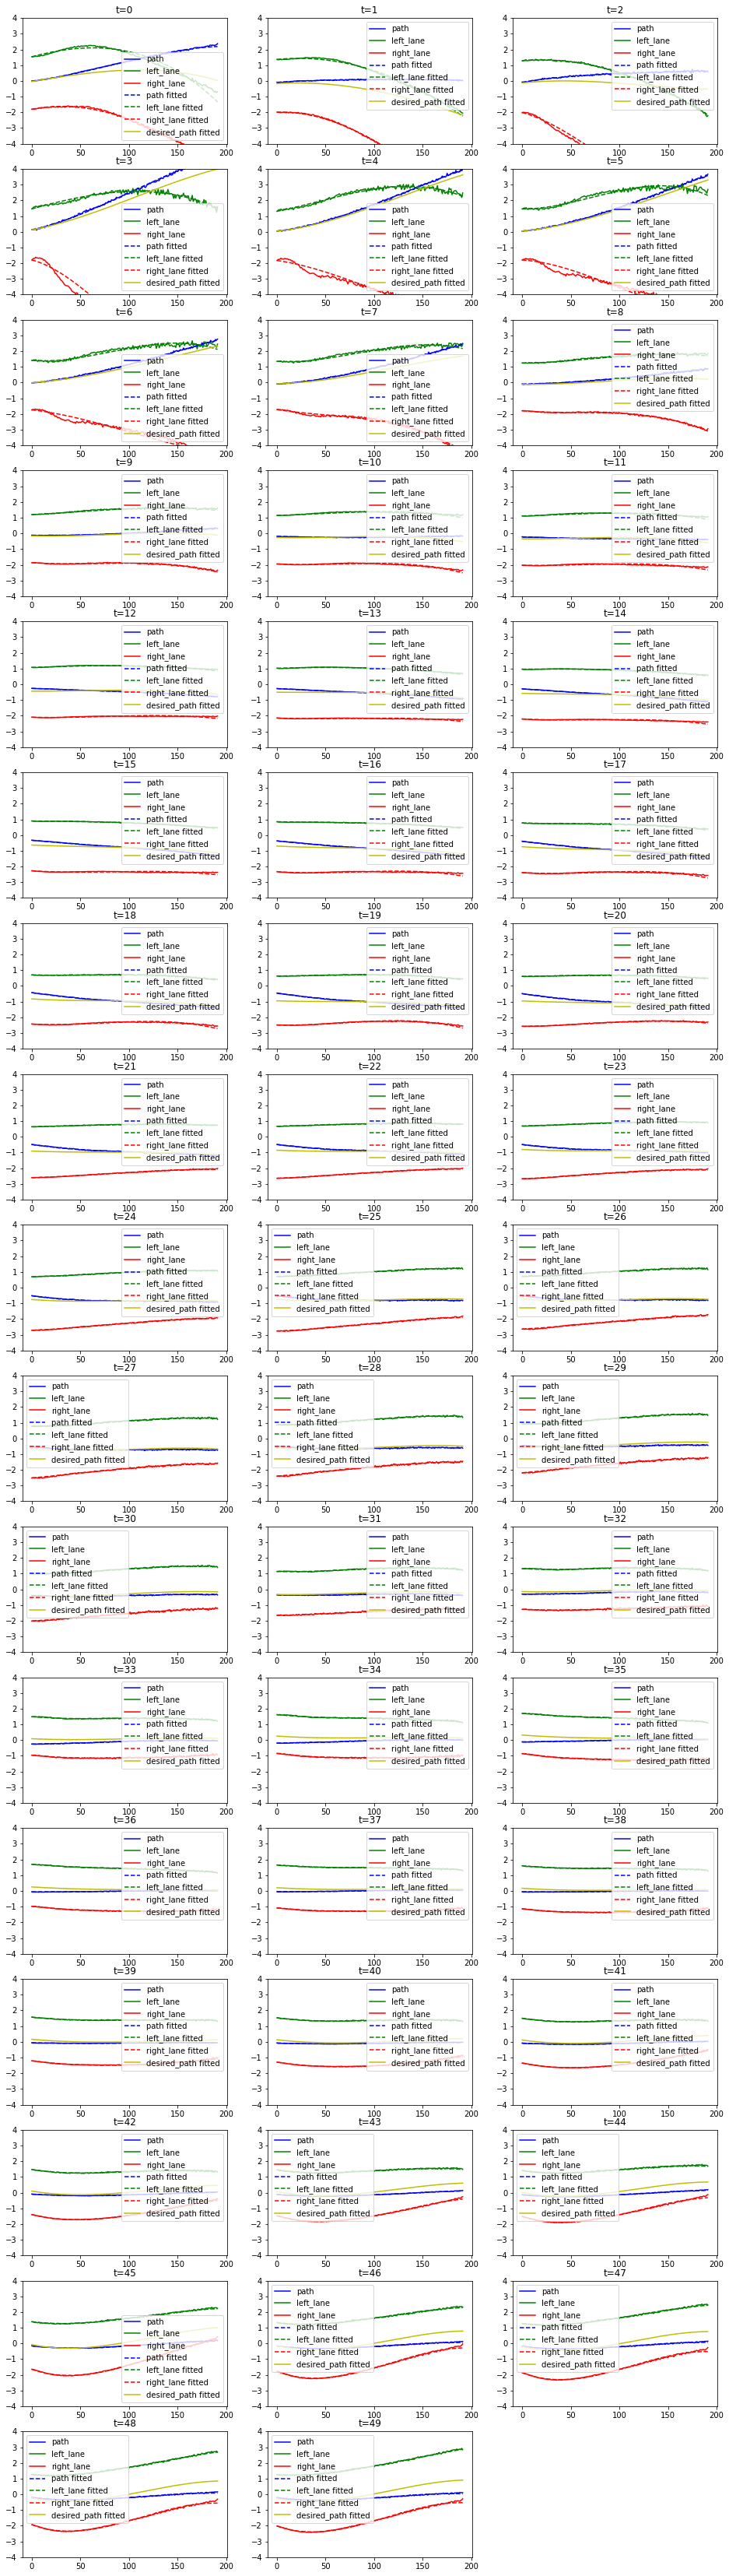

In [11]:
plt.figure(figsize=(16, 60))
for t in range(all_data.shape[0]):
    ax = plt.subplot(all_data.shape[0] // 3 + 1, 3, t + 1)
    list_dfs[t].plot(style=['-', '-', '-', '--', '--', '--'], 
                      color=['b', 'g', 'r', 'b', 'g', 'r', 'y'], title=f't={t}', ylim=(-4, 4), ax=ax)
plt.show()

### Attacked Trajectory

* cost: MPC cost. If it is more than 20k, OpenPilot ask driver to take over.
* desired_steering_angle: Desired steering angle at the next frame. MPC output.
* current_steering_angle: Current steering angle, decided by the desired steering and steering change limit (1.25 deg/frame)
* lateral_deviation: lateral deviation from simulated benign OpenPilot driving. Left direction is 

In [12]:
def get_result_replay(path):
    res_lat = []
    res_str = []
    lateral_shift = total_lateral_shift = lateral_shift_openpilot = 0
    with open(path) as f:
        for line in f:
            if ': yaw_diff:' in line:
                paaa = line
                lateral_shift = float(line.strip().split(':')[-3].split(',')[0])
                total_lateral_shift = float(line.strip().split(':')[-2].split(',')[0])
                lateral_shift_openpilot = float(line.strip().split(':')[-1].split(',')[0])
                res_lat.append((lateral_shift_openpilot))
            elif ': valid:' in line:
                cost = float(line.strip().split(':')[-2].split(',')[0])
                line = f.readline()
                tmp = line.strip().split(':')
                desired_steering_angle = float(tmp[-2].split(',')[0])
                current_steering_angle = float(tmp[-1])
                res_str.append((cost, desired_steering_angle, current_steering_angle))
                
    df_lat = pd.DataFrame(res_lat, columns=['lateral_deviation']).tail(50).reset_index(drop=True)
    df_lat.loc[0, :] = 0
    df_str = pd.DataFrame(res_str, columns=['cost', 'desired_steering_angle', 'current_steering_angle']).tail(50).reset_index(drop=True)
    return pd.concat([df_str, df_lat], axis=1)
get_result_replay('logs/highway_sc1_left/run_patch_generation.py.log')

cost  desired_steering_angle  current_steering_angle  \
0   27.796111                2.014029               -0.429052   
1    9.390473                3.201142                0.820948   
2    9.259202                4.263148                2.070948   
3   20.636635                5.877031                3.320948   
4   23.639911                7.366372                4.570948   
5   27.648470                8.878707                5.820948   
6   22.119222                9.858227                7.070948   
7   15.800764               10.399006                8.320948   
8    7.524587                9.851579                9.570948   
9    6.242701                9.094486                9.851579   
10   6.240381                8.321773                9.094486   
11   6.097154                7.376760                8.321773   
12   7.591932                5.787759                7.376760   
13   8.514968                4.102582                6.126760   
14  10.172507                2.499713                4.876760   
15  10.744911                1.038236                3.626760   
16   9.809147               -0.081350                2.376760   
17   8.488740               -1.027589                1.126760   
18   6.962857               -1.661117               -0.123240   
19  10.378526               -2.188641               -1.373240   
20   9.934546               -2.634208               -2.188641   
21   8.516373               -2.821338               -2.634208   
22   6.541654               -2.796735               -2.821338   
23   4.392085               -2.562615               -2.796735   
24   2.936134               -2.162040               -2.562615   
25   4.052266               -2.085040               -2.162040   
26   1.524407               -1.708726               -2.085040   
27   1.302614               -1.268702               -1.708726   
28   1.487050               -1.079190               -1.268702   
29   1.550979               -0.845305               -1.079190   
30   1.677773               -0.701441               -0.845305   
31   3.678941               -0.064777               -0.701441   
32   4.478302                0.457793               -0.064777   
33   4.021181                0.772936                0.457793   
34   3.949324                0.975239                0.772936   
35   4.259609                1.116491                0.975239   
36   2.450361                1.144279                1.116491   
37   2.547777                1.224761                1.144279   
38   1.905181                1.186916                1.224761   
39   3.071099                0.998943                1.186916   
40   3.910392                0.878878                0.998943   
41   3.320615                0.726905                0.878878   
42   3.335434                0.586652                0.726905   
43   3.365070                0.417883                0.586652   
44   1.573495                0.431491                0.417883   
45   1.891005                0.328838                0.431491   
46   3.180357               -0.022506                0.328838   
47   3.241844               -0.284481               -0.022506   
48   3.370104               -0.523327               -0.284481   
49   3.683783               -0.694077               -0.523327   

    lateral_deviation  
0            0.000000  
1            0.000325  
2            0.002545  
3            0.008809  
4            0.020949  
5            0.040593  
6            0.069384  
7            0.108968  
8            0.160849  
9            0.226379  
10           0.305760  
11           0.398059  
12           0.502486  
13           0.617821  
14           0.742508  
15           0.875299  
16           1.014571  
17           1.158638  
18           1.305811  
19           1.454266  
20           1.602683  
21           1.749825  
22           1.895306  
23           2.038791  
24           2.180244  
25           2.319875  
26           2.458019  
27           2.594667

# Patch Image

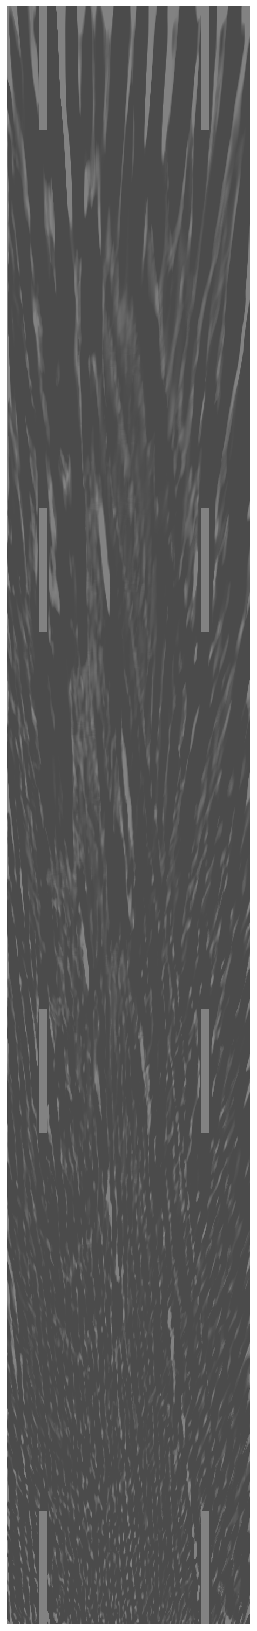

In [13]:
#path = 'logs_layered_0210_10f_40m_lgsvl_blur11/'
YUV_MIN = -8.68289960e-01
YUV_MAX = 4.87138199e-01
path = 'logs/highway_sc1_left/'
    
color = np.load(f'{path}/_global_base_color_{n}.npy')
color_6ch = np.array([color[0]] * 4 + [color[1]] + [color[2]])
yuv_patch = np.load(f'{path}/_global_masked_patch_{n}.npy')# + color_6ch

yuv_patch = (yuv_patch + color_6ch).clip(YUV_MIN, YUV_MAX)

LANE_INTERVAL = 93
LANE_WIDTH = 1.5
LANE_DOT_LENGTH = 23
for i in range(0, yuv_patch.shape[0], LANE_INTERVAL * scale):
    if  left_lane_pos is not None:
        yuv_patch[i:i + LANE_DOT_LENGTH *scale, 
                  left_lane_pos * scale:int((left_lane_pos + LANE_WIDTH) * scale), :4] = 0.
    if right_lane_pos is not None:
        yuv_patch[i:i + LANE_DOT_LENGTH * scale, 
                  right_lane_pos * scale:int((right_lane_pos + LANE_WIDTH) * scale), :4] = 0.
plt.figure(figsize=(20, 200))
ax = plt.subplot(1, 4, 1)
ax.axis('off')
rgb = yuv2rgb(yuv_patch).clip(0, 255).astype(np.uint8)

    
ax.imshow(rgb)

#from skimage import io
#io.imsave(f'patch.png', rgb.astype(np.uint8))